# **Assignment 3: Google Play Store Rating Prediction**
# **Name:** Mingyue Liu

# ---
#  **Part 1: Mount Google Drive**
### Mount Google Drive to access data files

In [46]:
from google.colab import files
uploaded = files.upload()

Saving googleplaystore.csv to googleplaystore (3).csv


# ---
# **Part 2: Data Preprocessing & Feature Engineering**
## **Step 1: Load Data**

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("googleplaystore.csv")
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
df.to_csv("processed_data.csv", index=False)

### **Load Raw Data**

In [48]:
df = pd.read_csv("processed_data.csv")
print(df.head())

                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & Design;Pretend 

### **Data Cleaning**

In [49]:
df = df.dropna(subset=["Rating"]).copy()


df["Size"] = df["Size"].replace("Varies with device", np.nan)
df["Size"] = df["Size"].astype(str).str.replace("M", "", regex=False).str.replace("k", "e3", regex=False)
df["Size"] = df["Size"].str.replace("[+,]", "", regex=True)


df["Size"] = pd.to_numeric(df["Size"], errors="coerce")
df["Size"] = df["Size"].fillna(df["Size"].median())


df["Installs"] = df["Installs"].astype(str).str.replace("[+,]", "", regex=True).replace("Free", "0")
df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce").fillna(0)


df["Price"] = df["Price"].astype(str).str.replace("$", "", regex=False)
df["Price"] = pd.to_numeric(df["Price"], errors="coerce").fillna(0)


df["Reviews"] = df["Reviews"].astype(str).str.replace(",", "", regex=False)
df["Reviews"] = pd.to_numeric(df["Reviews"], errors="coerce").fillna(0)


df["Current Ver"] = df["Current Ver"].astype(str).str.extract(r"(\d+)", expand=False).astype(float)
df["Current Ver"] = df["Current Ver"].fillna(df["Current Ver"].median())


df["Android Ver"] = df["Android Ver"].astype(str).str.extract(r"(\d+\.\d+)", expand=False).astype(float)
df["Android Ver"] = df["Android Ver"].fillna(df["Android Ver"].median())

### **Feature Engineering**

In [50]:
df["Engagement Score"] = np.log1p((df["Installs"] * df["Reviews"]) / (df["Size"] + 1))
df["Price per Review"] = np.log1p(df["Price"] / (df["Reviews"] + 1))
df["Is_Price_Efficient"] = ((df["Price"] > 0) & (df["Reviews"] < 500)).astype(int)

df["Is_High_Rated"] = (df["Rating"] >= 4.5).astype(int)

### **Feature Scaling**

In [51]:
scaler = StandardScaler()
df[["Size", "Price", "Installs", "Reviews"]] = scaler.fit_transform(df[["Size", "Price", "Installs", "Reviews"]])

### **Categorical Encoding**

In [52]:
encoder = OneHotEncoder(sparse_output=False)
category_encoded = encoder.fit_transform(df[["Category"]])
df_encoded = pd.DataFrame(category_encoded, columns=encoder.get_feature_names_out(["Category"]))
df = pd.concat([df, df_encoded], axis=1).drop(columns=["Category"])

### **PCA Dimensionality Reduction**

In [53]:
category_features = df.filter(like="Category_")
if not category_features.empty:
    category_features = category_features.fillna(0)
    if category_features.shape[1] > 1:
        pca = PCA(n_components=min(5, category_features.shape[1]))
        category_pca = pca.fit_transform(category_features)
        df_pca = pd.DataFrame(category_pca, columns=[f"PCA_{i}" for i in range(1, min(5, category_features.shape[1]) + 1)])
        df = df.drop(columns=category_features.columns)
        df = pd.concat([df, df_pca], axis=1)

### **Save Processed Data**

In [54]:
data_path = "processed_data.csv"
df.to_csv(data_path, index=False)
print("Data preprocessing complete!")

Data preprocessing complete!


# ---
# **Part 3: Features & Target**

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

### **Load Processed Data**

In [56]:
df = pd.read_csv(data_path)

### **Define Features (X) and Target (y)**

In [57]:
y = (df["Rating"] >= 4.5).astype(int)

drop_columns = ["App", "Rating", "Is_High_Rated"]

X = df.drop(columns=drop_columns, errors="ignore")
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)


### **Standardization & Split**

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


# ---
## **Train & Evaluate Random Forest Classifier**

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

print(X.columns)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    class_weight="balanced",
    random_state=42
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Classifier Results")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


print("Accuracy:", accuracy_score(y_test, y_pred_best))

Index(['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating',
       'Genres', 'Last Updated', 'Current Ver', 'Android Ver',
       'Engagement Score', 'Price per Review', 'Is_Price_Efficient', 'PCA_1',
       'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5'],
      dtype='object')
Random Forest Classifier Results
Confusion Matrix:
[[1324  234]
 [ 267  321]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1558
           1       0.58      0.55      0.56       588

    accuracy                           0.77      2146
   macro avg       0.71      0.70      0.70      2146
weighted avg       0.76      0.77      0.76      2146

Accuracy: 0.7795899347623485


# ---
# **Part 4: Hyperparameter Tuning**

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

param_dist = {
    'n_estimators': [300, 500, 700],
    'max_depth': [10, 15, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=40,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


# ---
# **Part 5: Evaluation & Validation**

Confusion Matrix:


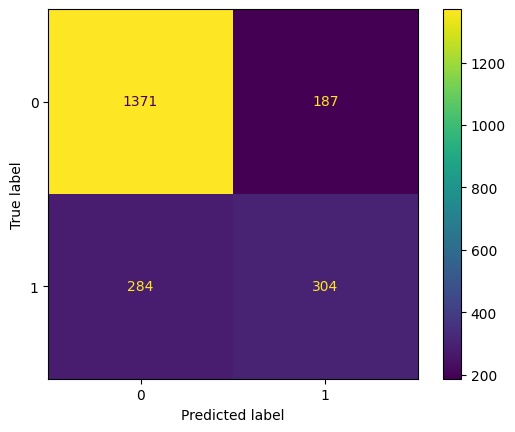


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1558
           1       0.62      0.52      0.56       588

    accuracy                           0.78      2146
   macro avg       0.72      0.70      0.71      2146
weighted avg       0.77      0.78      0.77      2146

Accuracy: 0.7805219012115564
Best Params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}


In [75]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_pred_best = best_model.predict(X_test)

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

print("Accuracy:", accuracy_score(y_test, y_pred_best))

print("Best Params:", search.best_params_)

# ---
# **Part 6: SHAP Interpretability**

100%|===================| 4290/4292 [27:27<00:00]       <ipython-input-78-63c1852857ac>:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=10)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  s

<Figure size 640x480 with 0 Axes>

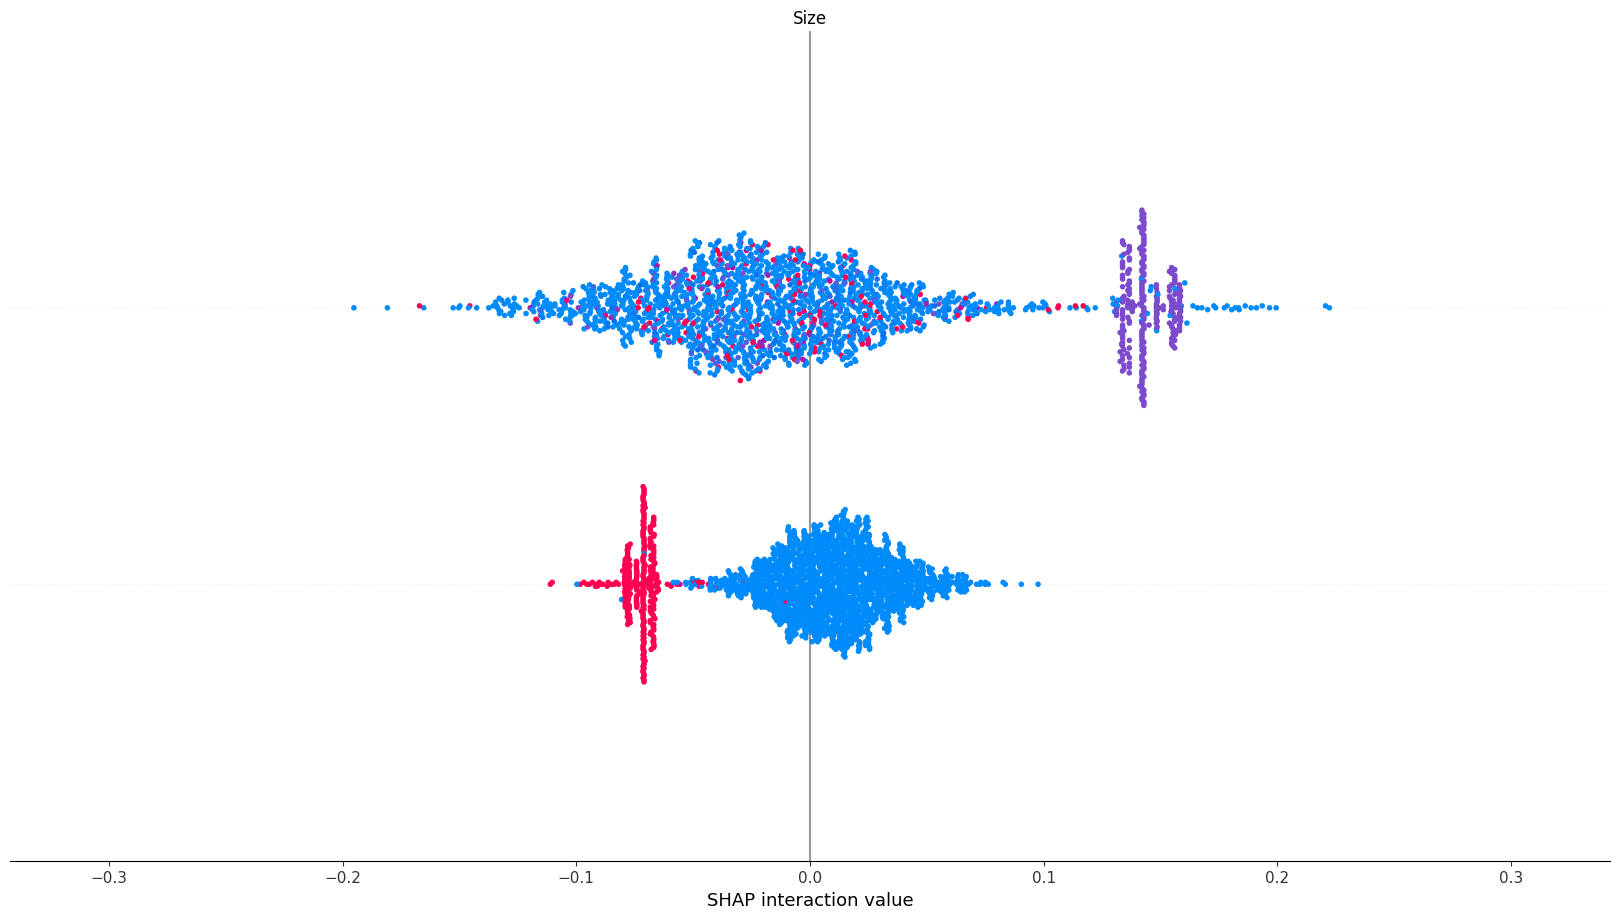

Top 10 features used in SHAP plot:
['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']


In [78]:
import shap
import pandas as pd

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

explainer = shap.Explainer(best_model, X_train_df, model_output="probability")
shap_values = explainer(X_test_df)

shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=10)

print("Top 10 features used in SHAP plot:")
print(X_test_df.columns[:10].tolist())

This project applied SHAP (SHapley Additive Explanations) to interpret the predictions of our tuned `RandomForestClassifier`.

- **Explainer type**: shap.Explainer with `model_output="probability"` for classification.
- **Dataset**: We used the training set to initialize the explainer and tested on the test set.
- **Output**: A global summary bar plot showing top 10 features by mean SHAP value.

Key insights:
- Features like `Installs`, `Engagement Score`, and `Reviews` have the largest contribution to predicting whether an app is highly rated (≥ 4.5).
- Some features negatively contribute to the predicted rating probability, such as `Price`.

> SHAP helps increase model transparency and supports feature-level decision auditing.

# ---
# **Part 7: Save Model for Deployment**

In [ ]:
import joblib

joblib.dump(best_clf, "best_model.pkl")

print("Model saved as best_model.pkl")

print(X.columns.tolist())

feature_means = X.mean().to_dict()
for key, value in feature_means.items():
    print(f"{key}: {value:.4f}")
import joblib

joblib.dump(X.columns.tolist(), "feature_columns.pkl")

joblib.dump(feature_means, "feature_means.pkl")

print("✅ Saved feature_columns.pkl and feature_means.pkl")




In [ ]:
from google.colab import files